 DSC-037 step 3: Assessment & Verfication 
---
DSC-037: Cable reflection systematics for EoR science

### Authors:
SHAO EoR Group and Teal Team

### Documentation on confluence:

Summary: This notebook is a first implementation of DSC-037 to plot amplitude and phase of calibration solutions to assess temporal and spectral smoothnessss.

DSC description page: https://confluence.skatelescope.org/x/0rs6F
Chronological walkthrough: https://confluence.skatelescope.org/x/osw6F
Implementation: https://confluence.skatelescope.org/x/n8LMF
GitHub repo: https://github.com/uksrc-developers/dsc-037-eor


Ticket: TEAL-1128 https://jira.skatelescope.org/browse/TEAL-1128

**Dependencies:**  `numpy`, `astropy`

Last updated: 2025-10-16

In [13]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import yaml

%matplotlib inline

In [14]:
def unwrap_phase_per_tile_pol(phases):
    """
    Unwrap each tile and pol of the three-dimensional phase array (tile, freq, pol) along the frequency axis.
    Safely handle NaN.

    Parameters
    ----------
    phases : np.ndarray
        A phase array with shapes of (ntile, nfreq, npol) in radians.

    Returns
    -------
    unwrapped : np.ndarray
        Same dimensional array, containing unwrapped phases and retaining NaN.
    """
    if phases.ndim != 3:
        raise ValueError(f"Input must be 3D (tile, freq, pol), got shape {phases.shape}")

    ntile, nfreq, npol = phases.shape
    unwrapped = np.full_like(phases, np.nan, dtype=float)

    for i_tile in range(ntile):
        for i_pol in range(npol):
            ph = phases[i_tile, :, i_pol]
            mask = np.isfinite(ph)
            if np.count_nonzero(mask) > 1:
                unwrapped_tile = np.full_like(ph, np.nan)
                unwrapped_tile[mask] = np.unwrap(ph[mask])
                unwrapped[i_tile, :, i_pol] = unwrapped_tile
            else:
                # Keep the original value when all NaN values are present or when there is only one value
                unwrapped[i_tile, :, i_pol] = ph

    return unwrapped

## Parameter Settings

Notebook-specific parameters are set below. 
For exmaple input_file

In [15]:
filename = "hyp_soln_1184702048_ssins_30l_src8k_300it.fits"

i_timeblock = 0
figsize = (18, 10)
output_amp = "./Amplitude Solutions vs Frequency.png"
output_phase = "./Phase Solutions vs Frequency.png"
dpi = 300
colors = {"xx": "blue", "yy": "green", "xy": "blue", "yx": "green"}
alpha_main = 0.6
alpha_cross = 0.2

## Open FITS file

In [16]:
f = fits.open(filename)
data = f["SOLUTIONS"].data
num_tiles = data.shape[1]
num_tiles_per_row = num_tiles // 16
name_tiles=f['TILES'].data

In [17]:
# Extract frequency axis (assuming it is in the SOLUTIONS header or inferred)
# Usually it can be obtained from another extension table or header; If not, use index instead
if "FREQS" in f:
    freqs = f["FREQS"].data
else:
    # fallback: Replace with channel index (in MHz)
    n_chan = data.shape[2]  # since there is re/im
    #n_chan = data.shape[2] // 2  # since there is re/im
    freqs = np.linspace(0, n_chan-1, n_chan)  # Occupation frequency, can be replaced with real MHz

## Select a time block

In [18]:
data = data[i_timeblock, :, :, ::2] + data[i_timeblock, :, :, 1::2] * 1j

## For amplitude part

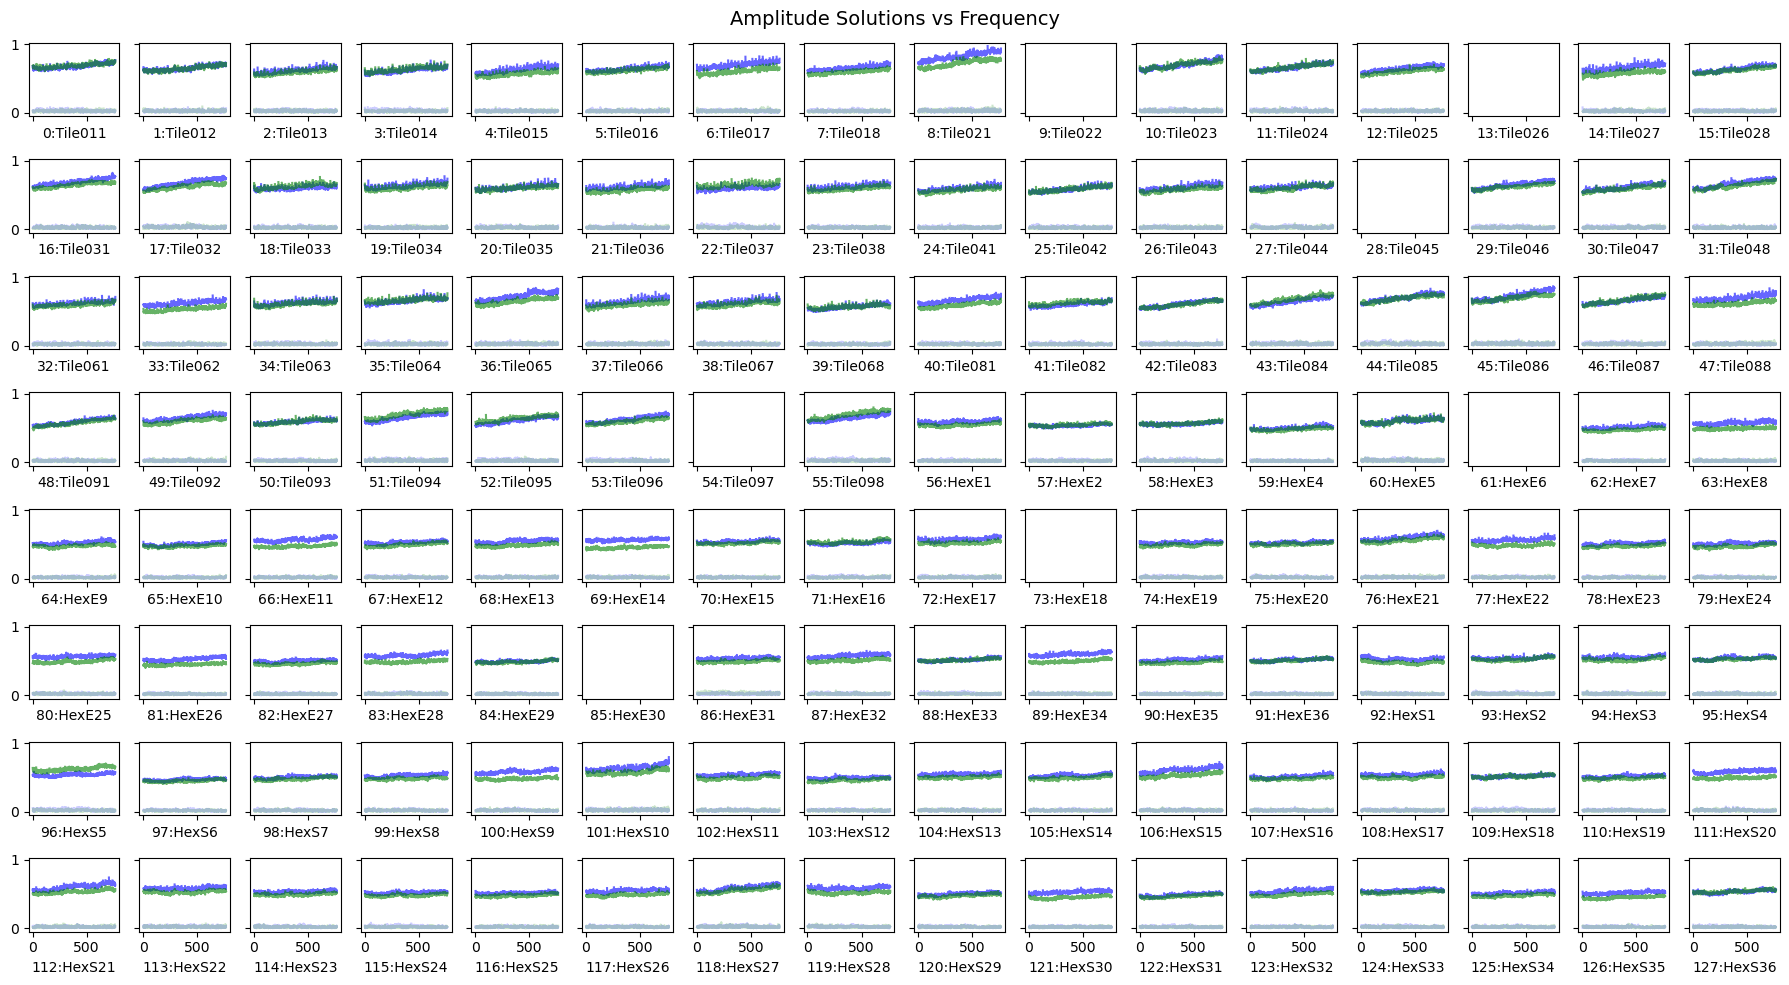

In [19]:
amps = np.abs(data)
fig_amp, ax_amp = plt.subplots(num_tiles_per_row, 16, sharex=True, sharey=True, figsize=figsize)
ax_amp = ax_amp.flatten()
smoothness_rms_amp = []

for i in range(num_tiles):
    xx = amps[i, :, 0].flatten()
    yy = amps[i, :, 3].flatten()
    xy = amps[i, :, 1].flatten()
    yx = amps[i, :, 2].flatten()
    ax_amp[i].plot(freqs, xx, color=colors['xx'], alpha=alpha_main)
    ax_amp[i].plot(freqs, yy, color=colors['yy'], alpha=alpha_main)
    ax_amp[i].plot(freqs, xy, color=colors['xy'], alpha=alpha_cross)
    ax_amp[i].plot(freqs, yx, color=colors['yx'], alpha=alpha_cross)
    ax_amp[i].set_xlabel('{0}:{1}'.format(i,name_tiles[i][2]))
fig_amp.suptitle("Amplitude Solutions vs Frequency", fontsize=14)
plt.tight_layout()
plt.savefig(output_amp, dpi=dpi, bbox_inches = 'tight')
plt.show()

## For phase part (consider ± 180° jump)

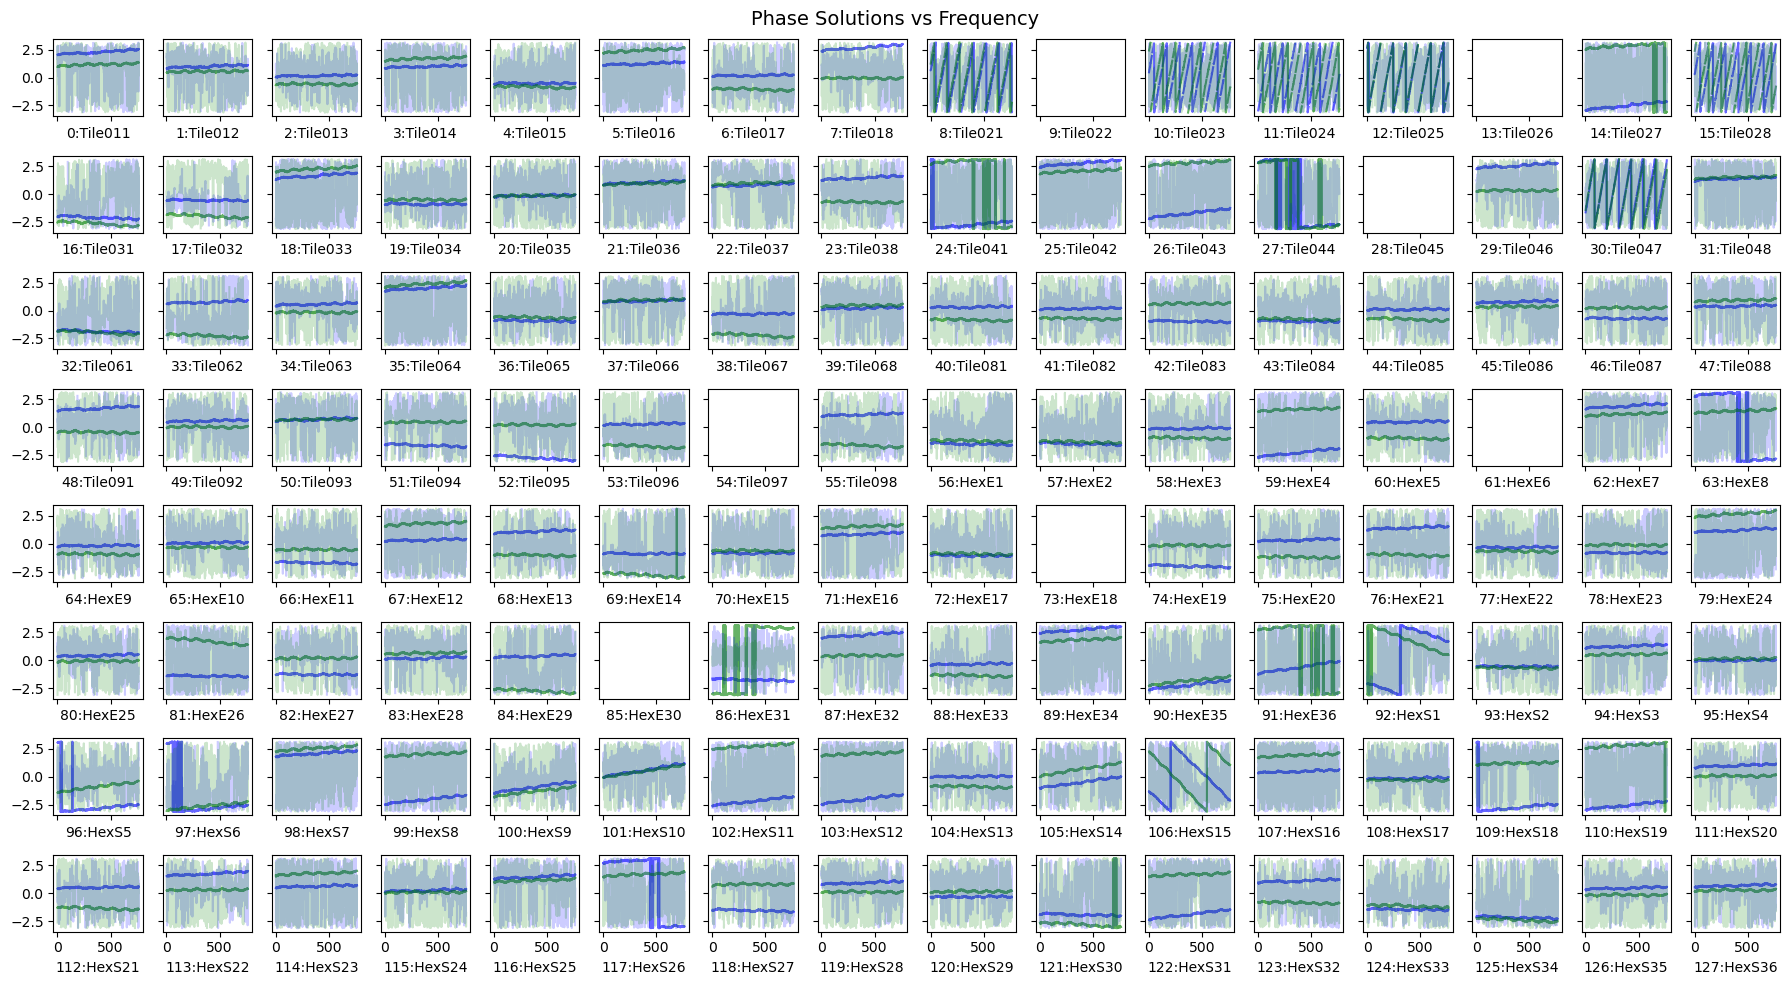

In [20]:
phases = np.angle(data)
unwrap_phases = unwrap_phase_per_tile_pol(phases)
fig_phase, ax_phase = plt.subplots(num_tiles_per_row, 16, sharex=True, sharey=True, figsize=figsize)
ax_phase = ax_phase.flatten()
smoothness_rms_phase = []

for i in range(num_tiles):
    xx = phases[i, :, 0].flatten() # Note: plotting original 'phases', not 'unwrap_phases'
    yy = phases[i, :, 3].flatten()
    xy = phases[i, :, 1].flatten()
    yx = phases[i, :, 2].flatten()
    ax_phase[i].plot(freqs, xx, color=colors['xx'], alpha=alpha_main)
    ax_phase[i].plot(freqs, yy, color=colors['yy'], alpha=alpha_main)
    ax_phase[i].plot(freqs, xy, color=colors['xy'], alpha=alpha_cross)
    ax_phase[i].plot(freqs, yx, color=colors['yx'], alpha=alpha_cross)
    ax_phase[i].set_xlabel('{0}:{1}'.format(i,name_tiles[i][2]))
fig_phase.suptitle("Phase Solutions vs Frequency", fontsize=14)
plt.tight_layout()
plt.savefig(output_phase, dpi=dpi, bbox_inches = 'tight')
plt.show()